In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import obe_jax as obj

import matplotlib.pyplot as plt
%matplotlib inline

# Fitting a simple linear function

Assume we have a system that takes in a single parameter $x$ and outputs a single output $y$.

The relationship between input and output variables is linear with known intercept but unknown slope.

$$y = mx+2$$


Also, let's assume that there is Gaussian noise with mean $y$ and standard deviation $\sigma$.

Our task is to observe $y$ for different inputs $x$ and infer both $m$ and $\sigma$ from the data.

### First we will define the true parameters that we are attempting to infer


In [2]:
m_true = 1.362
sigma_true = 0.12
true_params = jnp.asarray([m_true,sigma_true])

### Next we define the likelihood of observing an output $y'$ given an input x and a set of model parameters

In [3]:
@jax.jit
def y_mean(x,m):
    return m*x+2.0

@jax.jit
def likelihood_function(oneinput_vector,oneoutput_vector,oneparameter_vector):
    x = oneinput_vector[0]
    m, sigma = oneparameter_vector
    yout = oneoutput_vector[0]
    
    mu = y_mean(x,m)
    p = jnp.exp(-0.5*((mu-yout)/sigma)**2)/(jnp.sqrt(jnp.pi*2)*sigma)
    return p

### Next we define our initial guess regarding possible values of mu and sigma. 

### I.e., our "prior" knowledge of mu and sigma.

In [4]:
key = jax.random.PRNGKey(123)
key, subkey = jax.random.split(key)
N_particles = 1000
mins = jnp.array([0.,0.])
maxs = jnp.array([2.0,0.3])
prior_particles = obj.priors.uniform_prior_particles(subkey,mins,maxs,N_particles)
prior_weights = jnp.full((N_particles,),1/N_particles)

### And define the potential outputs we may observe

In [5]:
N_outcomes = 1000
expected_outcomes = jnp.linspace(0.0,10.0,N_outcomes).reshape((1,N_outcomes))

### Now we define our Bayseian model

In [6]:
key, subkey = jax.random.split(key)
pdf = obj.AbstractBayesianModel(subkey, prior_particles, prior_weights, expected_outcomes,
                                likelihood_function=likelihood_function)

In [7]:
pdf.mean()

Array([1.01334603, 0.15074503], dtype=float64)

### Next we will generate a synthetic dataset and visualize it

In [8]:
N_data_points = 100
inputs = jnp.linspace(0.,5., N_data_points).reshape((1,N_data_points))
outputs = pdf.sample_outputs(inputs,true_params)

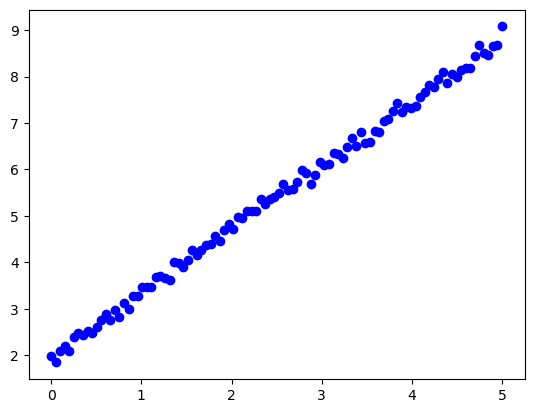

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(inputs[0,:],outputs[0,:],'bo')
plt.show()

### Now we will infer the systems parameters

In [11]:
pdf.batch_bayesian_update(inputs,outputs)

In [12]:
pdf.mean()

Array([1.36300116, 0.11279   ], dtype=float64)

In [13]:
pdf.covariance()

Array([[1.30038234e-05, 4.65138496e-07],
       [4.65138496e-07, 5.08132992e-05]], dtype=float64)

In [14]:
true_params

Array([1.362, 0.12 ], dtype=float64)

## Visualize the posterior distribution

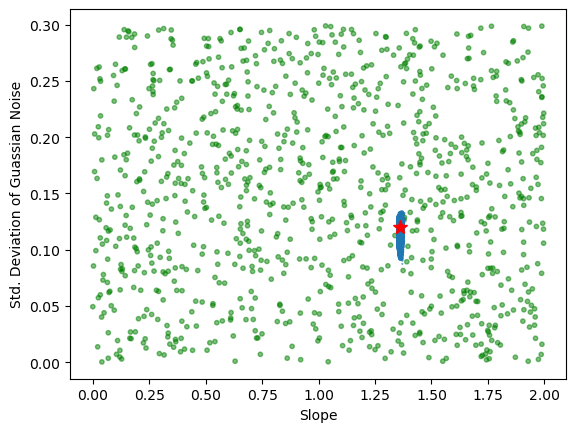

In [15]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[0,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[0,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[0],true_params[1],"r*",ms=10)
ax.set_xlabel("Slope")
ax.set_ylabel("Std. Deviation of Guassian Noise")
plt.show()